# Foundations-2025 — Linear Algebra, SVD Intuition & Calculus for Optimization

**Purpose:** Concise, Kaggle-ready notebook that reviews linear algebra essentials (matrix ops, eigendecomposition), gives SVD intuition and connections to PCA, and covers calculus tools used in optimization (gradients, Jacobians, Hessians). Includes runnable NumPy and SymPy examples, visualizations, and small optimization demos.

**Usage:** Run sequentially in a Kaggle kernel. Uses NumPy, SciPy, Matplotlib, and SymPy (available on Kaggle).


In [1]:
# Environment check (optional)
import sys, platform, numpy as np, scipy, matplotlib, sympy
import sklearn
print('Python:', sys.version.splitlines()[0])
print('Platform:', platform.platform())
print('NumPy:', np.__version__, 'SciPy:', scipy.__version__, 'matplotlib:', matplotlib.__version__)


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
NumPy: 1.26.4 SciPy: 1.15.3 matplotlib: 3.7.2


## Imports & small helpers
We define helpers for checking positive-definiteness, plotting eigen-spectra, and numerical gradient/Hessian checks.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eig, svd, eigvals
import sympy as sp
np.random.seed(0)

def is_pos_def(A):
    # check symmetric and eigenvalues > 0
    A_sym = 0.5 * (A + A.T)
    vals = np.linalg.eigvalsh(A_sym)
    return np.all(vals > 1e-10), vals

def plot_spectrum(vals, title='Eigenvalue spectrum'):
    plt.figure(figsize=(6,3))
    plt.plot(vals, marker='o')
    plt.yscale('log')
    plt.title(title)
    plt.xlabel('index'); plt.ylabel('eigenvalue (log)'); plt.grid(True)
    plt.show()


## 1) Basic matrix operations & properties
Quick review: rank, trace, determinant, transpose properties, and quadratic forms.

In [3]:
A = np.array([[3.0, 1.0],[1.0, 2.0]])
print('A:\n', A)
print('rank:', np.linalg.matrix_rank(A))
print('trace:', np.trace(A))
print('determinant:', np.linalg.det(A))

# quadratic form x^T A x
x = np.array([1.0, 2.0])
print('x^T A x =', x.T @ A @ x)


A:
 [[3. 1.]
 [1. 2.]]
rank: 2
trace: 5.0
determinant: 5.000000000000001
x^T A x = 15.0


## 2) Eigenvalues & eigenvectors — intuition and examples
For symmetric matrices eigenvectors form orthogonal basis; eigenvalues tell stretching factors. We'll compute and interpret them.

Eigenvalues: [3.61803399 1.38196601]
Eigenvectors (columns):
 [[ 0.85065081 -0.52573111]
 [ 0.52573111  0.85065081]]

Check A v - lambda v (should be near zero): 2.220446049250313e-16

Is A positive definite? True
Eigenvalues (sorted desc): [3.61803399 1.38196601]


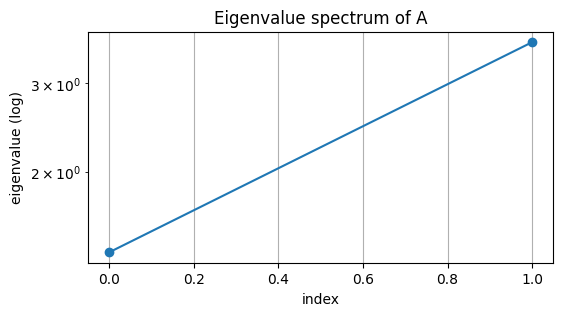

In [4]:
vals, vecs = eig(A)
print('Eigenvalues:', vals)
print('Eigenvectors (columns):\n', vecs)
# check A v = lambda v for first eigenpair
print('\nCheck A v - lambda v (should be near zero):', np.max(np.abs(A @ vecs[:,0] - vals[0]*vecs[:,0])))

# positive-definiteness
pd, pd_vals = is_pos_def(A)
print('\nIs A positive definite?', pd)
print('Eigenvalues (sorted desc):', np.sort(pd_vals)[::-1])
plot_spectrum(pd_vals, title='Eigenvalue spectrum of A')


## 3) Singular Value Decomposition (SVD) — geometry & relation to eigen-decomposition
SVD: X = U S V^T. Columns of V are right-singular vectors (directions in feature space). Singular values relate to energy/variance captured. For centered data, PCA directions = V (from SVD of X_centered).


Shapes U, S, Vt: (5, 3) (3,) (3, 3)
Reconstruct error (||M - U S Vt||_F): 1.3058401022944802e-15
Eigenvalues of M^T M: [ 0.59111   4.618053 12.516699]
Singular values squared: [12.516699  4.618053  0.59111 ]


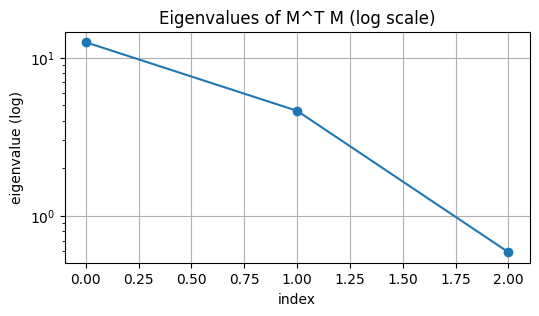

In [5]:
M = np.random.randn(5,3)
U, S, Vt = svd(M, full_matrices=False)
print('Shapes U, S, Vt:', U.shape, S.shape, Vt.shape)
print('Reconstruct error (||M - U S Vt||_F):', np.linalg.norm(M - U @ np.diag(S) @ Vt))

# Show connection: eigenvalues of M^T M equal S^2
vals_mt_m = np.linalg.eigvalsh(M.T @ M)
print('Eigenvalues of M^T M:', np.round(vals_mt_m,6))
print('Singular values squared:', np.round(S**2,6))
plot_spectrum(np.sort(vals_mt_m)[::-1], title='Eigenvalues of M^T M (log scale)')


### 3.1 SVD intuition with an image (low-rank approximation)
We create a grayscale image (matrix) and show low-rank reconstructions with increasing k to visualize how SVD captures structure.

Image shape: (143, 214)


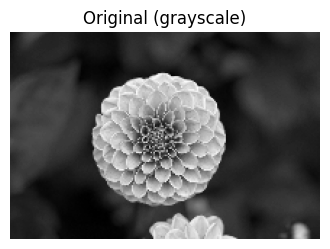

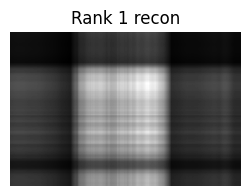

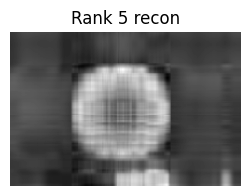

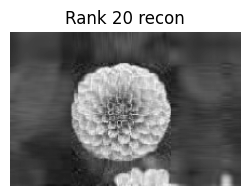

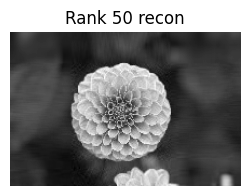

In [6]:
from sklearn.datasets import load_sample_image
# use an example image (flower) from sklearn
flower = load_sample_image('flower.jpg')
# convert to grayscale
img = np.dot(flower[...,:3], [0.2989, 0.5870, 0.1140])
# downsample for speed
img_small = img[::3, ::3]
print('Image shape:', img_small.shape)
plt.figure(figsize=(4,3)); plt.imshow(img_small, cmap='gray'); plt.title('Original (grayscale)'); plt.axis('off'); plt.show()

# SVD and rank-k reconstructions
U_img, S_img, Vt_img = svd(img_small, full_matrices=False)
for k in [1,5,20,50]:
    recon = U_img[:, :k] @ np.diag(S_img[:k]) @ Vt_img[:k, :]
    plt.figure(figsize=(3,2)); plt.imshow(recon, cmap='gray'); plt.title(f'Rank {k} recon'); plt.axis('off');
plt.show()


## 4) Calculus for optimization — gradients, Jacobians, Hessians
We cover scalar gradients, vector gradients, Jacobian matrices, and Hessian matrices. We'll use SymPy for symbolic derivatives and NumPy for numeric checks.

In [7]:
# Symbolic gradient & Hessian example for f(x,y) = 3x^2 + xy + 2y^2 - 4x
x, y = sp.symbols('x y')
f = 3*x**2 + x*y + 2*y**2 - 4*x
grad_f = [sp.diff(f, v) for v in (x,y)]
hess_f = sp.hessian(f, (x,y))
print('f =', f)
print('\nGradient (symbolic):', grad_f)
print('\nHessian (symbolic):\n', hess_f)

# Numeric evaluate gradient and Hessian at a point
f_grad_func = sp.lambdify((x,y), grad_f, 'numpy')
f_hess_func = sp.lambdify((x,y), hess_f, 'numpy')
print('\nNumeric grad at (1,1):', f_grad_func(1.0,1.0))
print('Numeric Hessian at (1,1):\n', f_hess_func(1.0,1.0))


f = 3*x**2 + x*y - 4*x + 2*y**2

Gradient (symbolic): [6*x + y - 4, x + 4*y]

Hessian (symbolic):
 Matrix([[6, 1], [1, 4]])

Numeric grad at (1,1): [3.0, 5.0]
Numeric Hessian at (1,1):
 [[6 1]
 [1 4]]


## 5) Quadratic forms & relation to convexity
For f(x)=1/2 x^T A x - b^T x + c, gradient = A x - b, Hessian = A. If A is positive definite, f is convex and has a unique minimizer at x* = A^{-1} b.


Analytic minimizer x*: [0.09090909 0.63636364]
Gradient at x* (should be near zero): [0. 0.]
GD solution: [0.09090909 0.63636364]


/tmp/ipykernel_13/4021261724.py:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.plot(hist); plt.title('GD on quadratic'); plt.yscale('log'); plt.grid(True); plt.show()


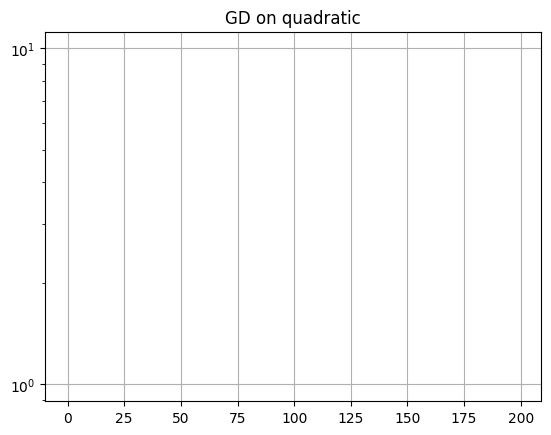

In [8]:
# small example
A = np.array([[4.0,1.0],[1.0,3.0]])
b = np.array([1.0,2.0])
# minimize f(x) = 0.5 x^T A x - b^T x
x_star = np.linalg.solve(A, b)
print('Analytic minimizer x*:', x_star)
# verify gradient zero
print('Gradient at x* (should be near zero):', A @ x_star - b)

# Use gradient descent to converge to x*
def gd_quad(A, b, x0, lr=0.1, epochs=200):
    x = x0.copy()
    hist = []
    for i in range(epochs):
        grad = A @ x - b
        x -= lr * grad
        hist.append(0.5 * x.T @ A @ x - b.T @ x)
    return x, np.array(hist)

x0 = np.zeros(2)
x_gd, hist = gd_quad(A, b, x0, lr=0.1, epochs=200)
print('GD solution:', x_gd)
plt.plot(hist); plt.title('GD on quadratic'); plt.yscale('log'); plt.grid(True); plt.show()


## 6) Numerical gradient & Hessian checks
We implement numerical finite-difference approximations to verify analytic gradients/Hessians.

In [9]:
def numerical_grad(f, x, eps=1e-6):
    x = x.astype(float)
    grad = np.zeros_like(x)
    for i in range(len(x)):
        xp = x.copy(); xm = x.copy()
        xp[i] += eps; xm[i] -= eps
        grad[i] = (f(xp) - f(xm)) / (2*eps)
    return grad

def numerical_hessian(f, x, eps=1e-5):
    n = len(x)
    H = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            e_i = np.zeros(n); e_j = np.zeros(n)
            e_i[i]=eps; e_j[j]=eps
            H[i,j] = (f(x+e_i+e_j) - f(x+e_i-e_j) - f(x-e_i+e_j) + f(x-e_i-e_j)) / (4*eps*eps)
    return H

# test on f(x)=3x^2 + xy + 2y^2 - 4x (converted to numeric function)
def f_num(v):
    x, y = v
    return 3*x**2 + x*y + 2*y**2 - 4*x

x0 = np.array([1.0,1.0])
print('Numeric grad:', numerical_grad(f_num, x0))
print('Sympy grad:', np.array(f_grad_func(1.0,1.0), dtype=float))
print('\nNumeric Hessian:\n', numerical_hessian(f_num, x0))
print('\nSympy Hessian:\n', np.array(f_hess_func(1.0,1.0), dtype=float))


Numeric grad: [3. 5.]
Sympy grad: [3. 5.]

Numeric Hessian:
 [[6.00000272 1.00000008]
 [1.00000008 4.00000255]]

Sympy Hessian:
 [[6. 1.]
 [1. 4.]]


## 7) Jacobian example (vector-to-vector)
For vector function F: R^n -> R^m, Jacobian J has entries J_ij = dF_i/dx_j. We'll show a small example and compute numeric Jacobian.

In [10]:
def F(v):
    x, y = v
    return np.array([x**2 + y, np.sin(x) + y**3])

# numeric Jacobian
def numerical_jacobian(F, x, eps=1e-6):
    m = F(x).size
    n = x.size
    J = np.zeros((m,n))
    for j in range(n):
        e = np.zeros(n); e[j]=eps
        J[:,j] = (F(x+e) - F(x-e)) / (2*eps)
    return J

x0 = np.array([0.5, -0.2])
print('F(x0):', F(x0))
print('Numeric Jacobian:\n', numerical_jacobian(F, x0))


F(x0): [0.05       0.47142554]
Numeric Jacobian:
 [[1.         1.        ]
 [0.87758256 0.12      ]]


## 8) Practical recommendations for optimization
- Use Hessian (or Gauss-Newton approximation) when available for fast convergence near optimum.  
- For large-scale ML, use first-order methods with momentum or adaptive steps (Adam).  
- Precondition with approximate inverse Hessian (L-BFGS) or use conjugate gradient for large symmetric positive-definite systems.  

**Extensions:** implement L-BFGS, conjugate gradient, and automatic differentiation checks with JAX/PyTorch for production-scale projects.


## Checklist before adding to portfolio
1. Add short explanations next to each code block summarizing takeaways.  
2. Save key plots (spectrum, image reconstructions, GD curves) as PNGs.  
3. Include a brief note on how linear algebra underpins PCA, SVD, and many ML algorithms.
